In [96]:
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import elementwise_grad

import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier

import pandas as pd
import scipy
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

np.random.seed(123) # set the seed

In [97]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        # polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.5
        linewidths= 0.1
        
    i = 0
    
    YY = np.zeros(models[0].predict(xx).shape).reshape((n, n))
    for model in models:

#         yy = model.predict_proba(xx)
        yy = model.predict_proba(xx)[:,1]
        
        # plot decision boundary
        yy = yy.reshape((n, n))
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        # calculate accumulated dicision surface in the for loop
        YY += yy  

    # Plot decision surface
    YY /= len(models)
    if shaded:
        if len(models)==1:
            vmin=0
            vmax=1
            levels = np.linspace(vmin, vmax, 20+1)
            img = ax.contourf(x1, x2, YY, cmap='bwr',levels=levels, alpha = .3, vmin=vmin, vmax=vmax)
            fig.colorbar(img)
        else:
            # ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
            vmin=0
            vmax=1
            levels = np.linspace(vmin, vmax, 20+1)
            img = ax.contourf(x1, x2, YY, cmap='bwr',levels=levels, alpha = 50./len(models), vmin=vmin, vmax=vmax)
            fig.colorbar(img)

        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

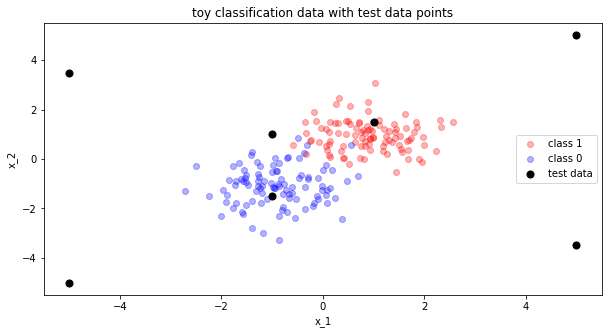

In [98]:
# Generate a toy dataset for classification

samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x_train = np.vstack((class_0, class_1))
y_train = np.array([0] * 100 + [1] * 100)

# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

# Visualize our test data points
x = x_train
y = y_train
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

In [105]:
# train a multi-layer perceptron logistic regression model on the data
# model_nn = MLPClassifier(solver='lbfgs',activation='relu', alpha=1e-5, hidden_layer_sizes=(3,3), random_state=1)
model_nn = MLPClassifier(solver='adam',activation='relu', alpha=1e-5, hidden_layer_sizes=(20,10,5), random_state=1,max_iter = 4000)
# max_iter=200
model_nn.fit(x, y);

# print out predict probablility for all six test points
for c,test_point in enumerate(test_points):
    test_point = np.array(test_point).reshape(1,-1)
    print(f' p({test_point} is class 0) = {(model_nn.predict_proba(test_point.reshape(1,-1)))[0][0]} p({test_point} is class 1) = {(model_nn.predict_proba(test_point.reshape(1,-1)))[0][1]}')

 p([[-5 -5]] is class 0) = 0.9999999996390813 p([[-5 -5]] is class 1) = 3.609187852464676e-10
 p([[-5.   3.5]] is class 0) = 0.9997916388226346 p([[-5.   3.5]] is class 1) = 0.00020836117736546423
 p([[5 5]] is class 0) = 4.5509450097291904e-08 p([[5 5]] is class 1) = 0.9999999544905499
 p([[ 5.  -3.5]] is class 0) = 0.3504358491075983 p([[ 5.  -3.5]] is class 1) = 0.6495641508924017
 p([[-1  1]] is class 0) = 0.6197031100613122 p([[-1  1]] is class 1) = 0.3802968899386879
 p([[-1.  -1.5]] is class 0) = 0.9987697744712363 p([[-1.  -1.5]] is class 1) = 0.0012302255287637398
 p([[1.  1.5]] is class 0) = 0.0036993529238864564 p([[1.  1.5]] is class 1) = 0.9963006470761135


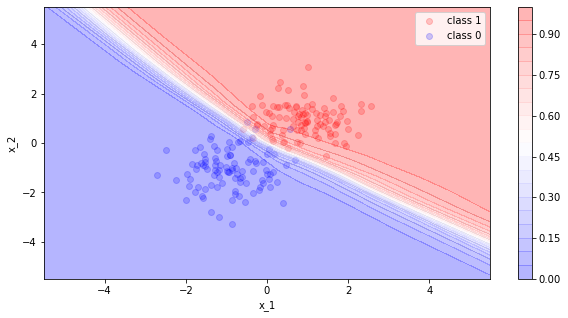

In [106]:
# visualize the decision boundary of the MLE solution of the nn

models = [model_nn]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x[:,:], y, models, ax, poly_degree=1,shaded =True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

# Bayesian NN (MLP) for binary classification

(**The Bayesian Neural Network Model**) We will implement the following Bayesian model for the data:<br>
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
z^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim Ber(\text{sigm}(z^{(n)}) ))
\end{align}
where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases).
<br><br>
Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.

In [52]:
### We first build a MLP NN with numpy

class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        x = x.T.reshape((1,D_in,-1))
        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']
        output = output.reshape(-1) # flatten it into a vector, to match the output format of logistic regression??
        return 1 / (1 + np.exp(-output)) # add a sigmoid activation to the output
    
    def forward_VI(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        x = x.T.reshape((1,D_in,-1))
        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']
#         output = output.reshape(-1) # flatten it into a vector, to match the output format of logistic regression??
        return 1 / (1 + np.exp(-output)) # add a sigmoid activation to the output
    
    
    
    
    

    def predict(self,x):
        y = self.forward(self.weights,x)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return np.array([1-self.forward(self.weights,x), self.forward(self.weights,x)]).T


    def make_objective(self, x_train, y_train, reg_param):### modify it to do binary classification

#         def objective(W, t):
#             squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
#             if reg_param is None:
#                 sum_error = np.sum(squared_error)
#                 return sum_error
#             else:
#                 mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
#                 return mean_error
        
        def objective(W, t):
            binary_cross_entropy = - (1/len(y_train.reshape(-1)))*(np.dot(y_train, np.log(self.forward(W,x_train))) + np.dot(1 - y_train, np.log(1-self.forward(W,x_train))))
            # print(binary_cross_entropy.shape)
            
            return binary_cross_entropy


        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        x_train = x_train.reshape((self.params['D_in'],-1))
        y_train = y_train.reshape((self.params['D_out'],-1))

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 1000
        # weights_init = self.weights.reshape((1, -1))
        weights_init = self.weights
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
#                 adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
                sgd(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)

            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [9]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#instantiate a Feedforward neural network object
# nn = Feedforward(architecture, random=random) # initiate W randomly

# ###define design choices in gradient descent
# params = {'step_size':1e-3, 
#           'max_iteration':15000, 
#           'random_restarts':1}

# #fit my neural network to minimize BCE on the given data  ### we are not using this and will use sklearn for maximum likelihood inference
# nn.fit(x_train, y_train, params)

In [10]:
## todo: add a function to unpack weights for NN 

In [11]:
#instantiate a Feedforward neural network object, initiate W with the MLE solution learnt by sklearn

# copy the weights from the sklearn model
MLE_weights = []
for a,b in zip(model_nn.coefs_,model_nn.intercepts_):
    MLE_weights = MLE_weights + list(np.array(a).flatten(order= 'F')) + list(np.array(b).flatten())
MLE_weights = np.array(MLE_weights).reshape(1,-1)

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)
nn = Feedforward(architecture, random=random, weights = MLE_weights) 

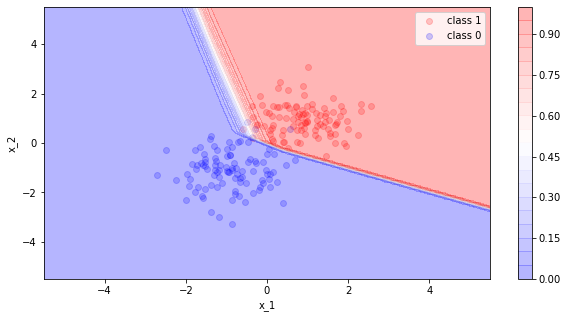

In [12]:
#Visualize the decision boundary of the nn with the MLE solution

models = [nn]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x[:,:], y, models, ax, poly_degree=1,shaded =True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [13]:
# Implement the log of the joint distribution
def log_joint(x,y,weights,nn):
    
    N = x.shape[0]# number of samples
    
    output = nn.forward(weights, x)
    
    w_cov = 25*np.eye(nn.D)
    w_inv = np.linalg.inv(w_cov)
    
    log_prior = -0.5*nn.D*np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(w_cov)) - 0.5*np.matmul(np.matmul(weights,w_inv),weights.T)
    
    log_condition = - (1/N)* (np.dot(y, np.log(1e-10 + output)) + np.dot(1 - y, np.log(1e-10 + 1-output)))
    return log_prior + log_condition

In [14]:
# HMC 

def leap_frog(position_init, momentum_init, step_size, leapfrog_steps, potential_energy, kinetic_energy):        # initialize position
        position = position_init
        # initialize momentum
        momentum = momentum_init

        # compute the gradient of potential energy
        potential_energy_grad = grad(potential_energy)

        # compute the gradient of kinetic energy
        kinetic_energy_grad = grad(kinetic_energy)

        # print(momentum)
        # print(position)
        # full leap frog steps
        for _ in range(leapfrog_steps - 1):
            # half step update of momentum
#             print(momentum)
#             print(position)
            momentum = momentum - step_size * 0.5 * potential_energy_grad(position)
#             print(potential_energy_grad(position))
#             print(momentum)
#             print(position)
            # full step update of position
            position = position + step_size * kinetic_energy_grad(momentum)
#             print(kinetic_energy_grad(momentum))
            # print(momentum)
#             print(position)
            # half step update of momentum
            momentum = momentum - step_size * 0.5 * potential_energy_grad(position)
            # print(position)
#             print(potential_energy_grad(position))
            assert not np.any(np.isnan(position))
            assert not np.any(np.isnan(momentum))

        # print(momentum)
        # print(position)
        # Reverse momentum
        momentum = -momentum
        return position, momentum

def hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler):

        ### Define total energy
        total_energy = lambda q, p: potential_energy(q) + kinetic_energy(p)

        ### Sample momentum
        # Make sure that the distribution from which you sample the momentum matches 
        # with your kinetic energy function
        momentum_current = momentum_sampler(1) 

        # print(momentum_current)
        # print(position_current)
        ### Simulate Hamiltonian dynamics using Leap Frog
        position_proposal, momentum_proposal = leap_frog(position_current.copy(), momentum_current.copy(), step_size, leapfrog_steps, potential_energy, kinetic_energy)

        # compute total energy in current position and proposal position
        current_total_energy = total_energy(position_current, momentum_current)
        proposal_total_energy = total_energy(position_proposal, momentum_proposal)

        ### Metropolis Hastings Step
        # comute accept probability
        accept_prob = min(1,np.exp(current_total_energy - proposal_total_energy))

        # accept proposal with accept probability
        if np.random.rand() < accept_prob:
            accept = 1
            position_current = np.copy(position_proposal)
            momentum_current = np.copy(momentum_proposal)
        else:
            accept = 0
            
        return position_current, momentum_current, accept

In [15]:
### Setting up the energy functions for HMC
potential_energy = lambda q: -log_joint(x_train,y_train,q,nn)
kinetic_energy = lambda p: np.sum(0.5*np.power(p,2))
momentum_sampler = lambda n: np.random.normal(0,1,size = nn.D)

### Setting up hyperparameters of HMC
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = nn.weights
position_current = position_init

momentum_current = momentum_sampler(1)
step_size = 0.005
leapfrog_steps = 20

### Running HMC to sample from a target distribution
total_trials = 10000 # 5000
burn_in = 0.1
thin = 2
samples = [position_current]
accepts = 0.

for t in range(total_trials):
    position_current, momentum_current, accept = hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler)
    samples.append(position_current)
    accepts += accept
    if t % 1000 == 0 and t > 0:
        print('{} iterations, accept rate: {}'.format(t, accepts / (t + 1.)))

accept_rate = accepts / total_trials
samples = np.array(samples[int(total_trials*burn_in)::thin])

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(21, 2, figsize=(10, 45))

for i in range(21):
    ax[i, 0].hist(samples[:, 0,i], bins=50, density=True, label=f"coef{i}")
    ax[i, 1].plot(samples[:, 0,i], label=f"coef{i}")

    ax[i, 0].legend()
    ax[i, 1].legend()

In [ ]:
#Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model (see In-Class Exercise 10.13)
# posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)
posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)
models_nn = []

for index in posterior_samples_index:
    sample = np.array(samples[index]).reshape(1,-1)
    model = Feedforward(architecture, weights = sample)
    models_nn.append(model)

In [ ]:
# Estimate the epistemic uncertainty of each test data point

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x[:,:], y, models_nn, ax, poly_degree=1)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for c,test_point in enumerate(test_points):
    test_pred_prob = np.zeros(100)
    test_point_ = test_point
    test_point = np.array(test_point).reshape(1,-1)
    
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index]
        model = Feedforward(architecture, weights = sample)
        test_pred_prob[c] = model.predict_proba(test_point)
        
    if c == 0:    
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the variance of the predict probability):{np.var(test_pred_prob)}')
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [16]:
def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return np.array(mean), np.array(log_std)

    def negative_gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = np.random.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = negative_gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [17]:
# def log_joint(x,y,weights,nn):
    
#     N = x.shape[0]# number of samples
    
#     output = nn.forward(weights, x)
    
#     w_cov = 25*np.eye(nn.D)
#     w_inv = np.linalg.inv(w_cov)
    
#     log_prior = -0.5*nn.D*np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(w_cov)) - 0.5*np.matmul(np.matmul(weights,w_inv),weights.T)
    
#     log_condition = - (1/N)* (np.dot(y, np.log(1e-10 + output)) + np.dot(1 - y, np.log(1e-10 + 1-output)))
#     return log_prior + log_condition

In [27]:
def variational_inference_BNN(Sigma_W, y_train, x_train, forward, S, max_iteration, step_size, verbose,init_W = None):
    '''implements wrapper for variational inference via bbb for bayesian NN'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    N = x_train.shape[0]
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
#         print(log_p_W)
        return log_p_W

    #define the log likelihood
#     def log_lklhd(W):
#         S = W.shape[0]
#         constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
#         exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - forward(W, x_train))**2, axis=2).flatten()
#         return constant + exponential
    def log_lklhd(W):
#         print(forward(W, x_train).shape)
        output = forward(W, x_train)
        
#         print((y_train.reshape(-1,1) * np.log(output))[-3:])
        log_condition = np.sum(y_train * np.log(output + 1e-10) + (1- y_train) * (np.log(1-output+1e-10)),axis = 2)
#         print(log_condition.shape)


#         output = forward(W, x_train)
#         argument = (1e-10+output)**y_train + (1e-10 + 1-output)**(1-y_train)
#         log_condition = sp.special.logsumexp(argument, axis=2)
#         print(log_condition.shape)
        return log_condition
    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 500 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    if init_W is not None:
        init_mean = init_W.flatten()
    else:
        init_mean = np.ones(D)
    init_log_std = -1 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

In [76]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = 3
hidden_layers = 2
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

nn = Feedforward(architecture, random=random) 

D = nn.D
weight_noise = 3**2
Sigma_W = weight_noise * np.eye(D)


BNN_paras = variational_inference_BNN(Sigma_W, y_train, x_train, nn.forward_VI, S = 100, max_iteration=100000, step_size=1e-3, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -571.5727115605958; gradient mag: 349.5226279726576
Iteration 500 lower bound -235.42507331184257; gradient mag: 143.97133336238102
Iteration 1000 lower bound -151.46104642158588; gradient mag: 70.48955185974968
Iteration 1500 lower bound -119.34957948680635; gradient mag: 52.177105800721165
Iteration 2000 lower bound -99.55250628891085; gradient mag: 37.71879026914149
Iteration 2500 lower bound -84.26591129223479; gradient mag: 28.542093375420794
Iteration 3000 lower bound -75.35383438956592; gradient mag: 21.280768811147627
Iteration 3500 lower bound -71.5238641263618; gradient mag: 19.478592835806747
Iteration 4000 lower bound -65.13035744204736; gradient mag: 15.484151381175753
Iteration 4500 lower bound -57.740327844973166; gradient mag: 11.735078757032467
Iteration 5000 lower bound -55.88452500278615; gradient mag: 9.26664219878035
Iteration 5500 lower bound -52.387038425940545; gradient mag: 7.021816889615709
Iteration

In [ ]:
mean, log_std = BNN_paras[:D], BNN_paras[D:]
samples = np.random.randn(1000, D) * np.exp(log_std) + mean

posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)
models_nn = []

for index in posterior_samples_index:
    sample = np.array(samples[index]).reshape(1,-1)
    model = Feedforward(architecture, weights = sample)
    models_nn.append(model)

 estimated epistemic uncertainty of test point [[-5 -5]] (the variance of the predict probability):0.0329768556295834
 estimated epistemic uncertainty of test point [[-5.   3.5]] (the variance of the predict probability):0.058923708015756644
 estimated epistemic uncertainty of test point [[5 5]] (the variance of the predict probability):3.316374938389455e-22
 estimated epistemic uncertainty of test point [[ 5.  -3.5]] (the variance of the predict probability):0.1143617841685994
 estimated epistemic uncertainty of test point [[-1  1]] (the variance of the predict probability):0.08346166511153788
 estimated epistemic uncertainty of test point [[-1.  -1.5]] (the variance of the predict probability):0.0005413064003127623
 estimated epistemic uncertainty of test point [[1.  1.5]] (the variance of the predict probability):2.1717879016920705e-08


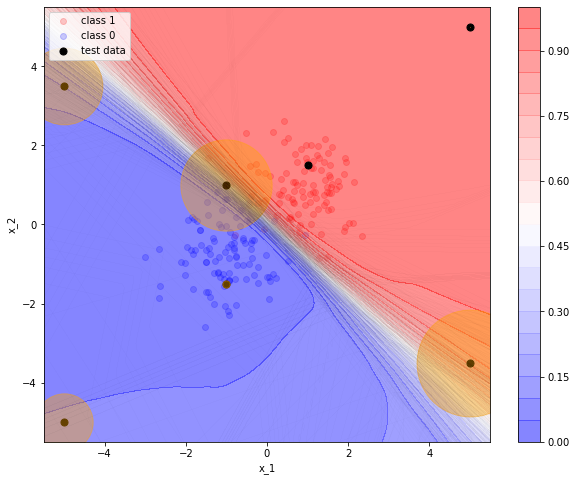

In [ ]:
# Estimate the epistemic uncertainty of each test data point

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x[:,:], y, models_nn, ax, poly_degree=1)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for c,test_point in enumerate(test_points):
    test_pred_prob = np.zeros(100)
    test_point_ = test_point
    test_point = np.array(test_point).reshape(1,-1)
    
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index].reshape(1,-1)
        model = Feedforward(architecture, weights = sample)
        test_pred_prob[c] = model.predict_proba(test_point)[:,1]
        
    if c == 0:    
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the variance of the predict probability):{np.var(test_pred_prob)}')
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [82]:
# try BBVI on two NN architectures
experiments = [(5,3),(15,1),]
# results = []
results_w1 = []

In [83]:
for ex in experiments:
    print(ex)
    width, hidden_layers = ex
    
    architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}
    
    nn = Feedforward(architecture, random=random) 

    D = nn.D
    sigma_y = 0.5**2
    weight_noise = 1**2
    Sigma_W = weight_noise * np.eye(D)


    BNN_paras = variational_inference_BNN(Sigma_W, y_train, x_train, nn.forward_VI, S = 100, max_iteration= 100000, step_size=1e-3, verbose=True)
    
    results_w1.append(BNN_paras)

(5, 3)
Optimizing variational parameters...
Iteration 0 lower bound -2372.9488417684847; gradient mag: 161.64028635203547
Iteration 500 lower bound -394.2856784200574; gradient mag: 382.87692818465257
Iteration 1000 lower bound -180.66042737540516; gradient mag: 98.85169558037443
Iteration 1500 lower bound -130.5759220426017; gradient mag: 84.50474628122707
Iteration 2000 lower bound -111.87493871024803; gradient mag: 38.229000864806174
Iteration 2500 lower bound -92.96982985403312; gradient mag: 26.84517077352819
Iteration 3000 lower bound -97.27347099429849; gradient mag: 20.635606561245936
Iteration 3500 lower bound -79.77194629827618; gradient mag: 17.058528195783815
Iteration 4000 lower bound -75.66096489219737; gradient mag: 15.6212371377025
Iteration 4500 lower bound -71.2679853672499; gradient mag: 12.023091761393822
Iteration 5000 lower bound -66.53649676551233; gradient mag: 13.89842385122936
Iteration 5500 lower bound -68.7176433775226; gradient mag: 11.054432604097315
Itera

In [88]:
results_w1[0].shape

(162,)

 estimated epistemic uncertainty of test point [[-5 -5]] (the variance of the predict probability):0.036958354035206586
 estimated epistemic uncertainty of test point [[-5.   3.5]] (the variance of the predict probability):0.09856222181369022
 estimated epistemic uncertainty of test point [[5 5]] (the variance of the predict probability):8.417332057248129e-17
 estimated epistemic uncertainty of test point [[ 5.  -3.5]] (the variance of the predict probability):0.16944056973969268
 estimated epistemic uncertainty of test point [[-1  1]] (the variance of the predict probability):0.09591347195915499
 estimated epistemic uncertainty of test point [[-1.  -1.5]] (the variance of the predict probability):0.0032350630282739685
 estimated epistemic uncertainty of test point [[1.  1.5]] (the variance of the predict probability):2.6475182517319014e-05


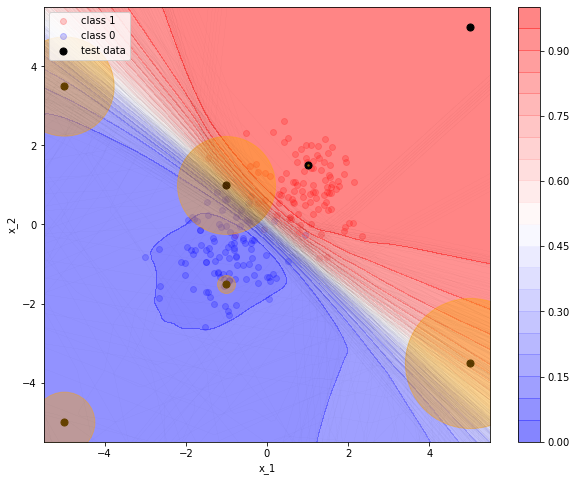

In [91]:
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}
nn = Feedforward(architecture, random=random)
BNN_paras = results_w1[0]
D = nn.D
mean, log_std = BNN_paras[:D], BNN_paras[D:]
samples = np.random.randn(1000, D) * np.exp(log_std) + mean

posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)
models_nn = []

for index in posterior_samples_index:
    sample = np.array(samples[index]).reshape(1,-1)
    model = Feedforward(architecture, weights = sample)
    models_nn.append(model)

# Estimate the epistemic uncertainty of each test data point

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x[:,:], y, models_nn, ax, poly_degree=1)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for c,test_point in enumerate(test_points):
    test_pred_prob = np.zeros(100)
    test_point_ = test_point
    test_point = np.array(test_point).reshape(1,-1)
    
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index].reshape(1,-1)
        model = Feedforward(architecture, weights = sample)
        test_pred_prob[c] = model.predict_proba(test_point)[:,1]
        
    if c == 0:    
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the variance of the predict probability):{np.var(test_pred_prob)}')
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

 estimated epistemic uncertainty of test point [[-5 -5]] (the variance of the predict probability):4.97490031347715e-06
 estimated epistemic uncertainty of test point [[-5.   3.5]] (the variance of the predict probability):0.12270997642894013
 estimated epistemic uncertainty of test point [[5 5]] (the variance of the predict probability):5.61530663194464e-12
 estimated epistemic uncertainty of test point [[ 5.  -3.5]] (the variance of the predict probability):0.15051943622617775
 estimated epistemic uncertainty of test point [[-1  1]] (the variance of the predict probability):0.10612898340688391
 estimated epistemic uncertainty of test point [[-1.  -1.5]] (the variance of the predict probability):0.002234075754900715
 estimated epistemic uncertainty of test point [[1.  1.5]] (the variance of the predict probability):0.00011235224543082482


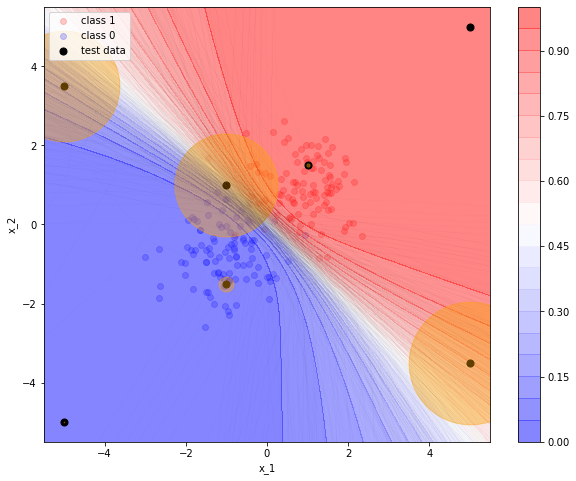

In [92]:
width = 15
hidden_layers = 1
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}
nn = Feedforward(architecture, random=random)
BNN_paras = results_w1[1]
D = nn.D
mean, log_std = BNN_paras[:D], BNN_paras[D:]
samples = np.random.randn(1000, D) * np.exp(log_std) + mean

posterior_samples_index = np.random.choice(np.arange(len(samples)), size=100)
models_nn = []

for index in posterior_samples_index:
    sample = np.array(samples[index]).reshape(1,-1)
    model = Feedforward(architecture, weights = sample)
    models_nn.append(model)

# Estimate the epistemic uncertainty of each test data point

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_decision_boundary(x[:,:], y, models_nn, ax, poly_degree=1)

for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
    

for c,test_point in enumerate(test_points):
    test_pred_prob = np.zeros(100)
    test_point_ = test_point
    test_point = np.array(test_point).reshape(1,-1)
    
    for c,index in enumerate(posterior_samples_index):
        sample = samples[index].reshape(1,-1)
        model = Feedforward(architecture, weights = sample)
        test_pred_prob[c] = model.predict_proba(test_point)[:,1]
        
    if c == 0:    
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange', label = 'ttt')
    else:
        ax.scatter(test_point_[0], test_point_[1], alpha=.4, s=100000*np.var(test_pred_prob), color='orange')
        
    print(f' estimated epistemic uncertainty of test point {test_point} (the variance of the predict probability):{np.var(test_pred_prob)}')
    
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()